# [ML2] Homework 1
LT5 - Castillo, Cruz, Madarang, Valera

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("../../data/international-airline-passengers.csv")
df = df.iloc[:-1]
df.columns = ["month", "passengers_thousands"]

df["month"] = pd.to_datetime(df["month"], format="%Y-%m")

df.head()

,month,passengers_thousands
0,1949-01-01,112.0
1,1949-02-01,118.0
2,1949-03-01,132.0
3,1949-04-01,129.0
4,1949-05-01,121.0


In [3]:
df.dtypes

month                   datetime64[ns]
passengers_thousands           float64
dtype: object

In [4]:
print(df["month"].min())
print(df["month"].max())

1949-01-01 00:00:00
1960-12-01 00:00:00


In [5]:
df.head()

,month,passengers_thousands
0,1949-01-01,112.0
1,1949-02-01,118.0
2,1949-03-01,132.0
3,1949-04-01,129.0
4,1949-05-01,121.0


## Data Preparation

In [6]:
train_df = df[df["month"].dt.year<1960]
train_df.head()

,month,passengers_thousands
0,1949-01-01,112.0
1,1949-02-01,118.0
2,1949-03-01,132.0
3,1949-04-01,129.0
4,1949-05-01,121.0


In [7]:
val_df = df[df["month"].dt.year==1960]
val_df.head()

,month,passengers_thousands
132,1960-01-01,417.0
133,1960-02-01,391.0
134,1960-03-01,419.0
135,1960-04-01,461.0
136,1960-05-01,472.0


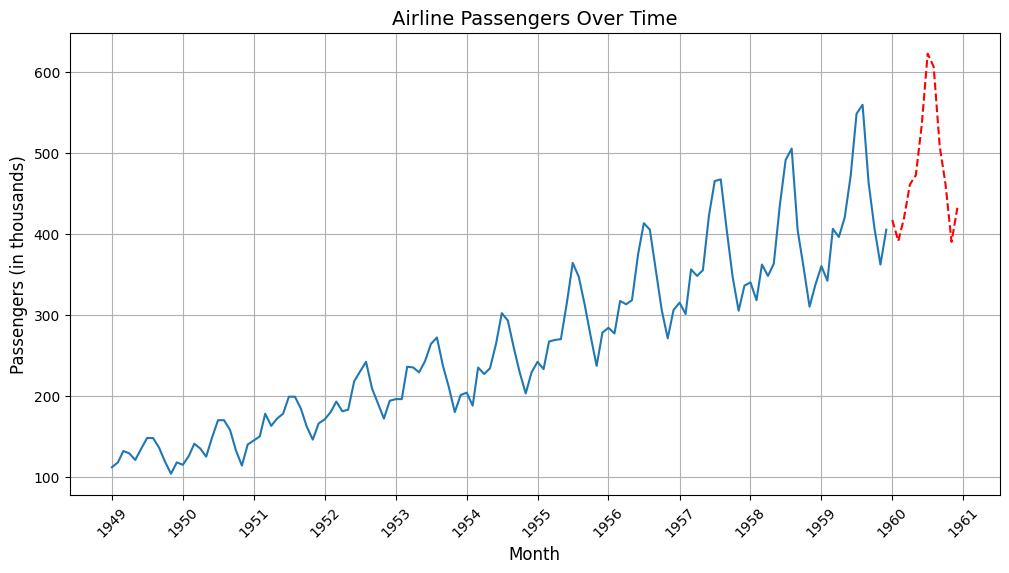

In [8]:
years = list(df["month"].dt.year.unique())
years.append(max(years) + 1)

plt.figure(figsize=(12, 6))
plt.plot(train_df["month"], train_df["passengers_thousands"])
plt.plot(val_df["month"], val_df["passengers_thousands"], color="r", linestyle="--")
plt.xticks(
    ticks=pd.to_datetime([f"{year}-01-01" for year in years]), 
    labels=years, 
    rotation=45  # Rotate for better readability if needed
)
plt.title("Airline Passengers Over Time", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Passengers (in thousands)", fontsize=12)
plt.grid(True)
plt.show()

### Create deseasonalized dataset

In [9]:
from statsmodels.tsa.stattools import adfuller

In [10]:
def difference(dataset, interval=1):
    diff = []
    for i in range(interval, len(dataset)):
        value = float(dataset[i] - dataset[i - interval])
        diff.append(value)
    return pd.Series(diff)

ADF Statistic: -3.048011
p-value: 0.030648
Critical Values:
	1%: -3.488
	5%: -2.887
	10%: -2.580


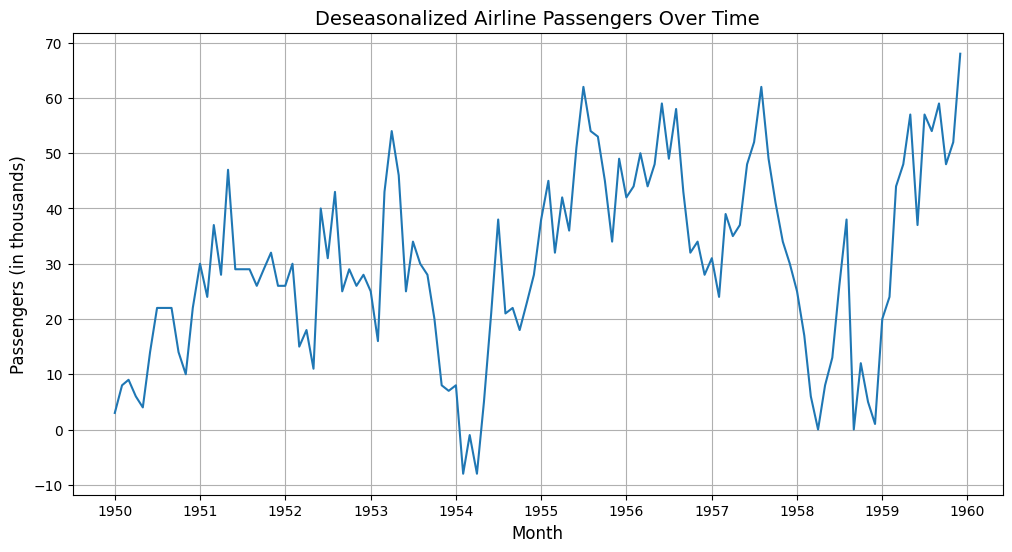

In [11]:
X = train_df["passengers_thousands"]
months_in_year = 12

stationary = difference(X, months_in_year)
stationary.index = train_df["month"][months_in_year:]

result = adfuller(stationary)
print("ADF Statistic: %f" % result[0])
print("p-value: %f" % result[1])
print("Critical Values:")
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

plt.figure(figsize=(12, 6))
plt.plot(stationary.index, stationary)
plt.title("Deseasonalized Airline Passengers Over Time", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Passengers (in thousands)", fontsize=12)
plt.grid(True)
plt.show()

Given that the ADF statistic is `-3.048011` is smaller than the p-value `0.030648`, the system has no unit root and is therefore stationary.

### Select lag values for AR and MA

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

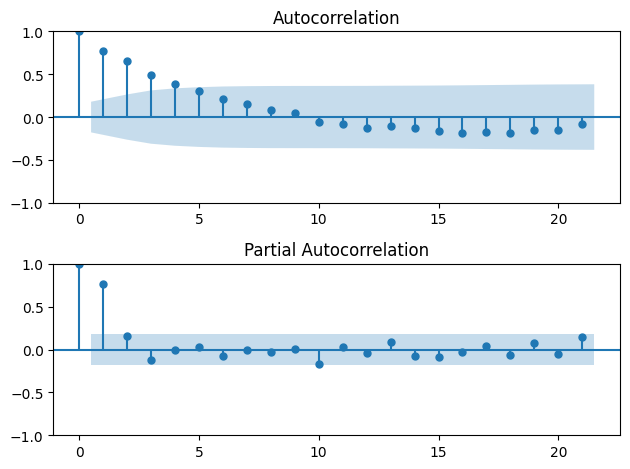

In [13]:
# Create a figure for subplots
plt.figure()

# Plot ACF (Autocorrelation Function) in the first subplot
plt.subplot(211)
plot_acf(stationary, ax=plt.gca())

# Plot PACF (Partial Autocorrelation Function) in the second subplot
plt.subplot(212)
plot_pacf(stationary, ax=plt.gca())

# Show the plots
plt.tight_layout()  # Ensure no overlapping between plots
plt.show()

### ARIMA

In [14]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt

from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter("ignore", ConvergenceWarning)

In [15]:
def inverse_difference(history, yhat, interval=1):
	return float(yhat + history[-interval])

In [16]:
X = train_df["passengers_thousands"]
X.index = train_df["month"]

X

month
1949-01-01    112.0
1949-02-01    118.0
1949-03-01    132.0
1949-04-01    129.0
1949-05-01    121.0
              ...  
1959-08-01    559.0
1959-09-01    463.0
1959-10-01    407.0
1959-11-01    362.0
1959-12-01    405.0
Name: passengers_thousands, Length: 132, dtype: float64

#### Default ARIMA order

In [17]:
train_size = int(len(X) * 0.80)
train, test = X[0:train_size], X[train_size:]

history = [x for x in train]
predictions = []
months_in_year = 12

for i in range(len(test)):
    diff = difference(history, months_in_year)
    
    model = ARIMA(diff)
    model_fit = model.fit()
    
    forecast = model_fit.forecast()
    
    yhat = inverse_difference(history, forecast.iloc[0], months_in_year)
    predictions.append(yhat)
    
    obs = test[i]
    history.append(obs)
    print(f">Predicted={yhat:.3f}, Expected={obs:.3f}")

>Predicted=336.065, Expected=347.000
>Predicted=301.181, Expected=305.000
>Predicted=336.221, Expected=336.000
>Predicted=345.219, Expected=340.000
>Predicted=331.165, Expected=318.000
>Predicted=386.031, Expected=362.000
>Predicted=377.788, Expected=348.000
>Predicted=384.490, Expected=363.000
>Predicted=451.277, Expected=435.000
>Predicted=494.118, Expected=491.000
>Predicted=496.087, Expected=505.000
>Predicted=433.173, Expected=404.000
>Predicted=375.895, Expected=359.000
>Predicted=333.736, Expected=310.000
>Predicted=364.514, Expected=337.000
>Predicted=368.259, Expected=360.000
>Predicted=346.183, Expected=342.000
>Predicted=390.145, Expected=406.000
>Predicted=376.288, Expected=396.000
>Predicted=391.464, Expected=420.000
>Predicted=463.717, Expected=472.000
>Predicted=519.789, Expected=548.000
>Predicted=534.035, Expected=559.000
>Predicted=433.250, Expected=463.000
>Predicted=388.504, Expected=407.000
>Predicted=339.661, Expected=362.000
>Predicted=366.849, Expected=405.000


RMSE: 20.441
MAE: 17.816


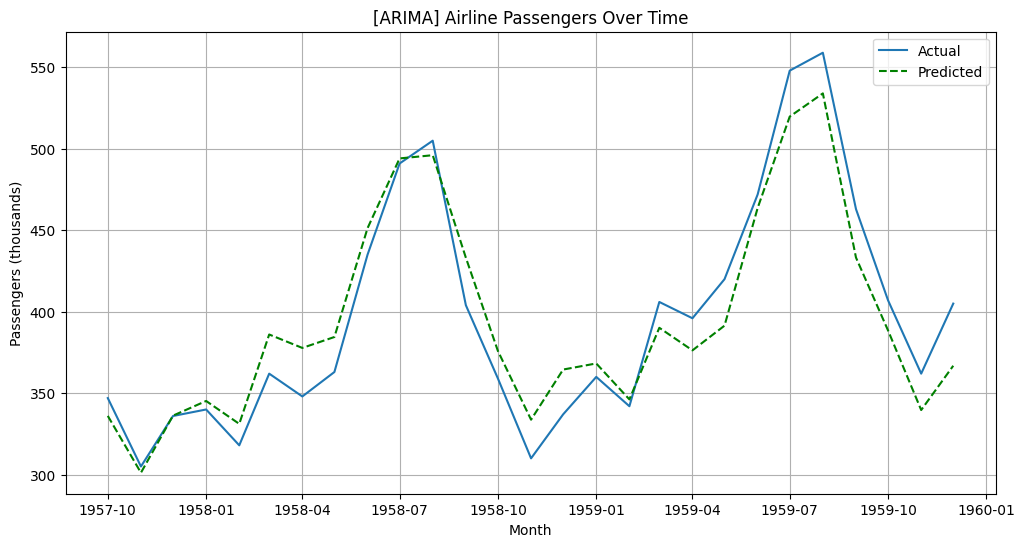

In [18]:
mse = mean_squared_error(test, predictions)
mae = mean_absolute_error(test, predictions)
rmse = sqrt(mse)

print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(test, label="Actual",)
plt.plot(test.index, predictions, label="Predicted", linestyle="--", color="green")

plt.title("[ARIMA] Airline Passengers Over Time")
plt.xlabel("Month")
plt.ylabel("Passengers (thousands)")

plt.legend()
plt.grid(True)
plt.show()

## (1) Forecast using ARIMA the last twelve months (1 year, January-December 1960) with the most optimal choice of p,d,q [10 pts]

In [19]:
import time

from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter("ignore", ValueWarning)

from typing import Optional, Union, List, Tuple, Dict, Any
from itertools import product

In [20]:
def evaluate_arima_model(
    X: Union[List[float], np.ndarray, pd.Series],
    order: Tuple[int, int, int],
    y: Optional[Union[List[float], np.ndarray, pd.Series]] = None,
    validation: bool = False,
) -> Union[float, Tuple[float, List[float]]]:
    
    if validation:
        history = [x for x in X]
        months_in_year = 12

        results = {}
        predictions = []

        model = ARIMA(X, order=order)
        model_fit = model.fit()

        forecast = model_fit.forecast()

        yhat = inverse_difference(history, forecast.iloc[0], months_in_year)
        predictions.append(yhat)

        history.append(y[0])
        print(">Predicted=%.3f, Expected=%.3f" % (yhat, y[0]))

        start_time = time.perf_counter()
        for t in range(1, len(y)):
            diff = difference(history, months_in_year)

            model = ARIMA(diff, order=order)
            model_fit = model.fit()

            forecast = model_fit.forecast()

            yhat = inverse_difference(history, forecast.iloc[0], months_in_year)
            predictions.append(yhat)

            obs = y[t]
            history.append(obs)
            
            print(">Predicted=%.3f, Expected=%.3f" % (yhat, obs))
        end_time = time.perf_counter()

        mse = mean_squared_error(y, predictions)
        rmse = sqrt(mse)

        mae = mean_absolute_error(y, predictions)
        results["rmse"] = rmse
        results["mae"] = mae
        results["runtime"] = end_time - start_time
        results["y"] = y
        results["yhat"] = predictions

        return results

    train_size = int(len(X) * 0.80)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    months_in_year = 12

    results = {}
    predictions = []

    start_time = time.perf_counter()
    for t in range(len(test)):
        diff = difference(history, months_in_year)

        model = ARIMA(diff, order=order)
        model_fit = model.fit()
        
        forecast = model_fit.forecast()

        yhat = inverse_difference(history, forecast.iloc[0], months_in_year)
        predictions.append(yhat)

        obs = test[t]
        history.append(obs)
    end_time = time.perf_counter()

    mse = mean_squared_error(test, predictions)
    rmse = sqrt(mse)

    mae = mean_absolute_error(test, predictions)

    results["rmse"] = rmse
    results["mae"] = mae
    results["runtime"] = end_time - start_time
    results["y"] = test
    results["yhat"] = predictions
 
    return results
        

In [21]:
p_range = range(0, 4)
d_range = range(0, 2)
q_range = range(0, 4)

rmse_results = {}
for p, d, q in product(p_range, d_range, q_range):
    order = (p, d, q)
    results = evaluate_arima_model(X=X, order=order)

    rmse = results["rmse"]
    rmse_results[order] = rmse

    print(f"Order {order}, RMSE: {rmse}")

Order (0, 0, 0), RMSE: 20.44119289127564
Order (0, 0, 1), RMSE: 16.03474448500369
Order (0, 0, 2), RMSE: 14.146867827658063
Order (0, 0, 3), RMSE: 12.892284121562017
Order (0, 1, 0), RMSE: 12.954335753515686
Order (0, 1, 1), RMSE: 12.940213948355337
Order (0, 1, 2), RMSE: 13.074519355605878
Order (0, 1, 3), RMSE: 12.957654464380385
Order (1, 0, 0), RMSE: 12.643366327399809
Order (1, 0, 1), RMSE: 12.66167884673632
Order (1, 0, 2), RMSE: 12.477491211313428
Order (1, 0, 3), RMSE: 12.657723174798011
Order (1, 1, 0), RMSE: 12.815013902663495
Order (1, 1, 1), RMSE: 12.776372248236495
Order (1, 1, 2), RMSE: 12.880998839651921
Order (1, 1, 3), RMSE: 13.105949625409803
Order (2, 0, 0), RMSE: 12.62485797946944
Order (2, 0, 1), RMSE: 12.741297543306105
Order (2, 0, 2), RMSE: 12.537240138889823
Order (2, 0, 3), RMSE: 12.65976803157613
Order (2, 1, 0), RMSE: 12.848654161798821
Order (2, 1, 1), RMSE: 12.865468703959962
Order (2, 1, 2), RMSE: 12.735547655764089
Order (2, 1, 3), RMSE: 13.2916906511538

In [22]:
best_order = min(rmse_results, key=rmse_results.get)
best_rmse = rmse_results[best_order]

print(f"\nBest Order: {best_order}, Lowest RMSE: {best_rmse}")


Best Order: (1, 0, 2), Lowest RMSE: 12.477491211313428


               0
count  27.000000
mean    1.017615
std    12.672822
min   -38.197029
25%    -5.784506
50%     2.560830
75%     8.569044
max    23.457425


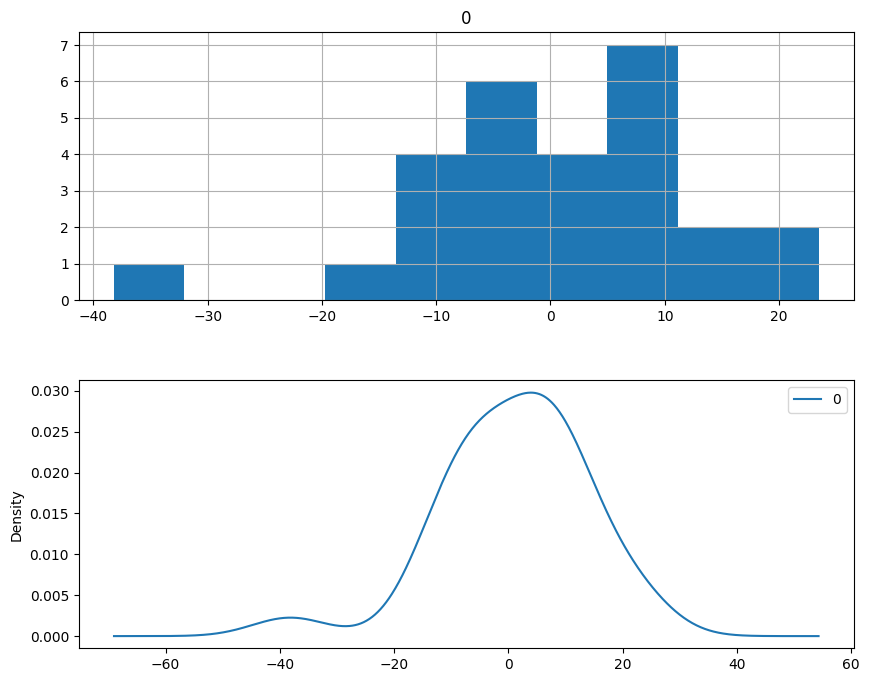

In [23]:
results = evaluate_arima_model(X=X, order=best_order)

test, predictions = results["y"], results["yhat"]

residuals = [test[i] - predictions[i] for i in range(len(test))]
residuals = pd.DataFrame(residuals)
print(residuals.describe())

plt.figure(figsize=(10, 8))

plt.subplot(211)
residuals.hist(ax=plt.gca())

plt.subplot(212)
residuals.plot(kind="kde", ax=plt.gca())

plt.show()

Mean is near zero. Should be fine.

### Validation

In [24]:
val = val_df["passengers_thousands"]
val.index = val_df["month"]

In [25]:
len(val)

12

In [26]:
arima_results = evaluate_arima_model(X=X, y=val, order=best_order, validation=True)

>Predicted=796.657, Expected=417.000
>Predicted=397.654, Expected=391.000
>Predicted=450.321, Expected=419.000
>Predicted=409.434, Expected=461.000
>Predicted=466.140, Expected=472.000
>Predicted=524.103, Expected=535.000
>Predicted=603.656, Expected=622.000
>Predicted=623.475, Expected=606.000
>Predicted=511.628, Expected=508.000
>Predicted=446.064, Expected=461.000
>Predicted=408.794, Expected=390.000
>Predicted=438.783, Expected=432.000


RMSE: 111.525
MAE: 47.160
Runtime: 0.273


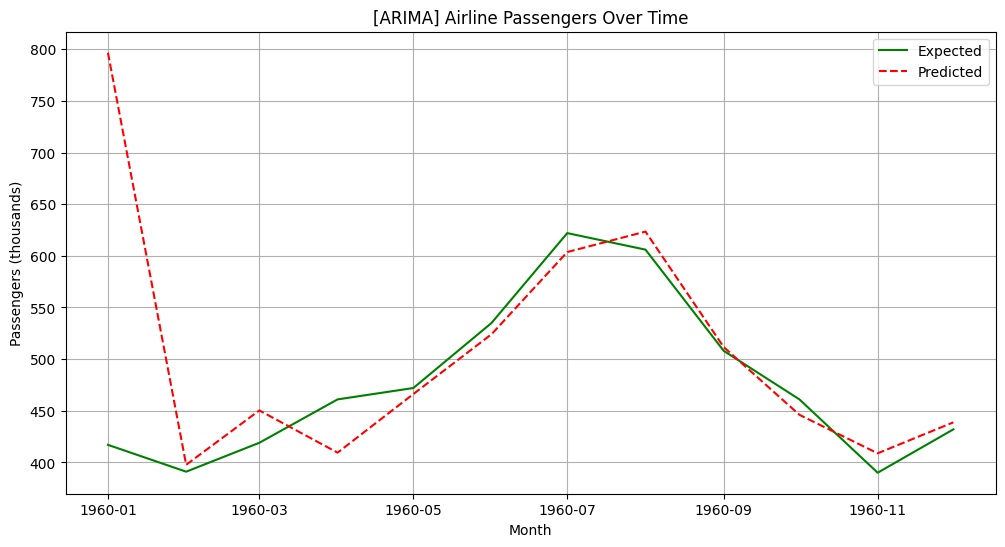

In [27]:
print("RMSE: %.3f" % arima_results["rmse"])
print("MAE: %.3f" % arima_results["mae"])
print("Runtime: %.3f" % arima_results["runtime"])

predictions = pd.Series(arima_results["yhat"])
predictions.index = val.index

plt.figure(figsize=(12, 6))
plt.plot(val, label='Expected', color="green")
plt.plot(predictions, color='red', linestyle="--", label='Predicted')

plt.title("[ARIMA] Airline Passengers Over Time")
plt.xlabel("Month")
plt.ylabel("Passengers (thousands)")
plt.legend()
plt.grid(True)
plt.show()

## (2) Compare the results' RMSE, MAE, and run time with optimal XGBoost. [10 pts]

In [28]:
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

In [29]:
df

,month,passengers_thousands
0,1949-01-01,112.0
1,1949-02-01,118.0
2,1949-03-01,132.0
3,1949-04-01,129.0
4,1949-05-01,121.0
...,...,...
139,1960-08-01,606.0
140,1960-09-01,508.0
141,1960-10-01,461.0
142,1960-11-01,390.0


In [30]:
new_train = df.set_index("month")
new_train

,passengers_thousands
month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0
...,...
1960-08-01,606.0
1960-09-01,508.0
1960-10-01,461.0


In [31]:
def create_features(df, label=None):
    if not df.index.freq:
        df.index = pd.date_range(start=df.index[0], periods=len(df), freq="MS")
        
    df["date"] = df.index
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month
    df["dayofyear"] = df["date"].dt.dayofyear
    df["dayofweek"] = df["date"].dt.dayofweek
    df["quarter"] = df["date"].dt.quarter
    X = df[["year", "month", "dayofyear", "dayofweek", "quarter"]]
    if label:
        y = df[label]
        return X, y
    return X

In [32]:
def create_lagged_features(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i].values)  # Previous 12 months
        y.append(data[i])  # Next month's value (target)
    return np.array(X), np.array(y)

In [33]:
def evaluate_xgb_model(
    train_set: Union[List[float], np.ndarray, pd.Series],
    label: str = "target",
    forecast_horizon: int = 12,
    window_size: int = 12,
    lag: bool = False,
    grid_search: bool = False,
    param_grid: Optional[Dict[str, Any]] = None,
) -> Union[float, Tuple[float, List[float]]]:
    forecast_horizon = 12

    train_size = len(train_set) - forecast_horizon
    train, forecast_period = train_set[:train_size], train_set[train_size:]

    if grid_search:
        X_train, y_train = create_lagged_features(train[label], window_size)

        xgb_model = XGBRegressor()
        tscv = TimeSeriesSplit(n_splits=5)

        grid_search = GridSearchCV(
            estimator=xgb_model,
            param_grid=param_grid,
            cv=tscv,
            scoring="neg_mean_squared_error",
            verbose=1,
            n_jobs=-1
        )

        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_

        print(f"Best Parameters: {grid_search.best_params_}")
        print(f"Best CV Score (neg_mean_squared_error): {grid_search.best_score_}")

        results = {}
        predictions = []

        start_time = time.perf_counter()
        for i in range(forecast_horizon):
            # Create feature for the next point to forecast using the last 'window_size' values
            X_next = train_set[label][train_size - window_size + i: train_size + i].values.reshape(1, -1)

            # Forecast the next point
            next_forecast = best_model.predict(X_next)
            predictions.append(next_forecast[0])

            # Update the training set with the observed value after the forecast
            X_train = np.vstack([X_train, X_next])
            y_train = np.append(y_train, forecast_period[label].iloc[i])

            best_model.fit(X_train, y_train)
        end_time = time.perf_counter()
        
        rmse = np.sqrt(mean_squared_error(forecast_period[label][:forecast_horizon], predictions))
        results["rmse"] = rmse
        print(f"RMSE for XGBoost 1-Year Forecast: {rmse}")

        mae = mean_absolute_error(forecast_period[label][:forecast_horizon], predictions)
        results["mae"] = mae
        print(f"MAE for XGBoost 1-Year Forecast: {mae}")

        results["runtime"] = end_time - start_time
        results["y"] = forecast_period
        results["yhat"] = predictions

        return results

    if lag:
        X_train, y_train = create_lagged_features(train[label], window_size)

        results = {}
        predictions = []

        start_time = time.perf_counter()
        for i in range(forecast_horizon):
            # Create feature for the next point to forecast using the last 12 months
            X_next = train_set[label][train_size-window_size+i:train_size+i].values.reshape(1, -1)

            # Initialize XGBoost model
            xgb_model = XGBRegressor()

            # Train the model
            xgb_model.fit(X_train, y_train)

            # Forecast the next point
            next_forecast = xgb_model.predict(X_next)
            predictions.append(next_forecast[0])

            # Update training set with actual observed value after the forecast
            X_train = np.vstack([X_train, X_next])
            y_train = np.append(y_train, forecast_period[label].iloc[i])
        end_time = time.perf_counter()

        rmse = np.sqrt(mean_squared_error(forecast_period[label][:forecast_horizon], predictions))
        results["rmse"] = rmse
        print(f"RMSE for XGBoost 1-Year Forecast: {rmse}")

        mae = mean_absolute_error(forecast_period[label][:forecast_horizon], predictions)
        results["mae"] = mae
        print(f"MAE for XGBoost 1-Year Forecast: {mae}")

        results["runtime"] = end_time - start_time
        results["y"] = forecast_period
        results["yhat"] = predictions

        return results

    X_train, y_train = create_features(train_set, label=label)
    X_forecast = create_features(forecast_period)

    results = {}
    xgb_model = XGBRegressor()
    xgb_model.fit(X_train, y_train)

    start_time = time.perf_counter()
    xgboost_forecast = xgb_model.predict(X_forecast[:forecast_horizon])
    end_time = time.perf_counter()
    
    print("Forecast:", xgboost_forecast)

    rmse = np.sqrt(mean_squared_error(forecast_period[label][:forecast_horizon], xgboost_forecast))
    results["rmse"] = rmse
    print(f"RMSE for XGBoost 1-Year Forecast: {rmse}")

    mae = mean_absolute_error(forecast_period[label][:forecast_horizon], xgboost_forecast)
    results["mae"] = mae
    print(f"MAE for XGBoost 1-Year Forecast: {mae}")

    results["runtime"] = end_time - start_time
    results["y"] = forecast_period[label][:forecast_horizon]
    results["yhat"] = xgboost_forecast

    return results


RMSE for XGBoost 1-Year Forecast: 30.27334257189803
MAE for XGBoost 1-Year Forecast: 23.56365712483724


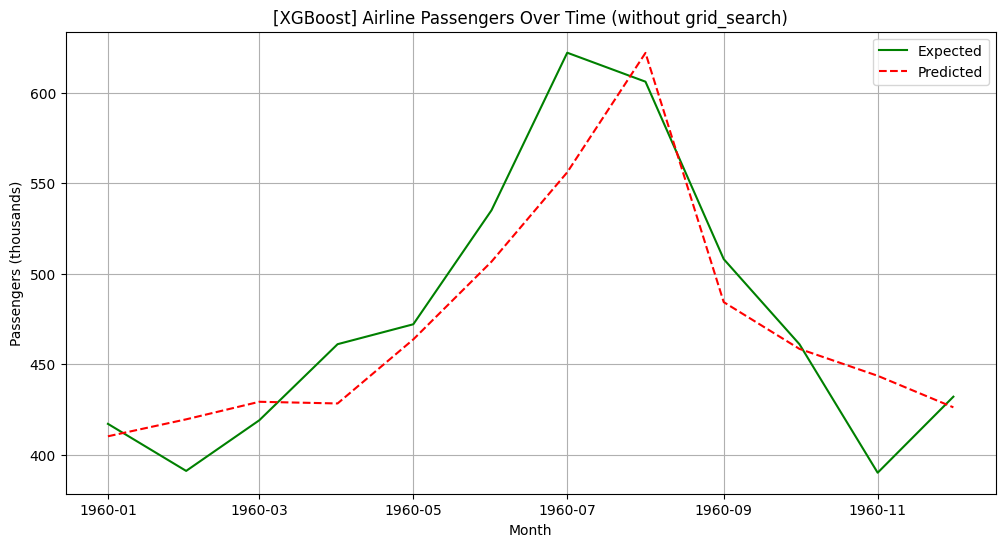

In [40]:
results = evaluate_xgb_model(train_set=new_train, label="passengers_thousands", lag=True,)

plt.figure(figsize=(12, 6))
plt.plot(results["y"].index, results["y"]["passengers_thousands"], label="Expected", color="green")
plt.plot(results["y"].index, results["yhat"], label="Predicted", linestyle="--", color="red")

plt.title(f"[XGBoost] Airline Passengers Over Time (without grid_search)")
plt.xlabel("Month")
plt.ylabel("Passengers (thousands)")
plt.legend()
plt.grid(True)
plt.show()


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.7}
Best CV Score (neg_mean_squared_error): -1551.4197462611132
RMSE for XGBoost 1-Year Forecast: 30.438575132364594
MAE for XGBoost 1-Year Forecast: 22.35386912027995


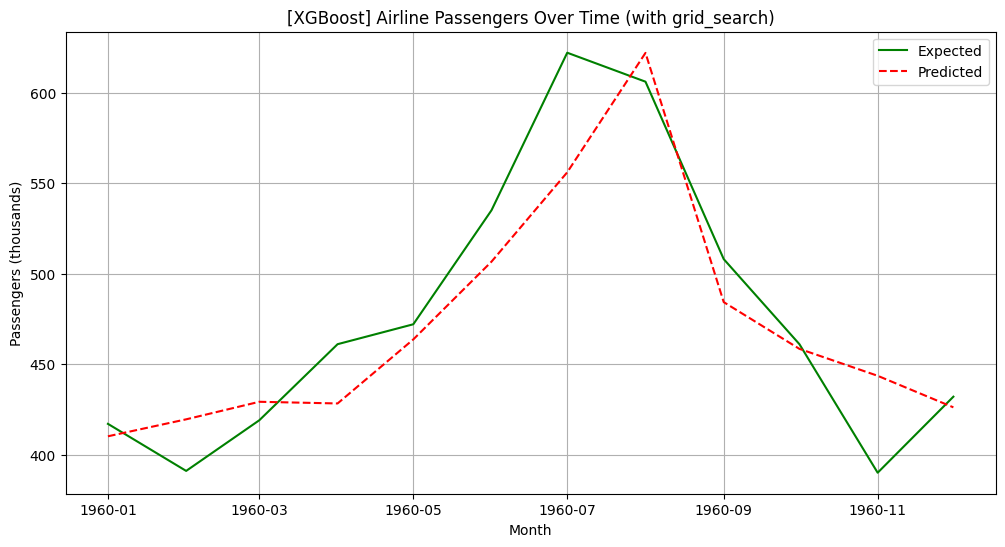

In [41]:
param_grid = {
    "n_estimators": [100, 300, 500],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 7],
    "subsample": [0.6, 0.7, 0.8],
    "colsample_bytree": [0.6, 0.7, 0.8]
}

xgb_results = evaluate_xgb_model(train_set=new_train, label="passengers_thousands", grid_search=True, param_grid=param_grid)

plt.figure(figsize=(12, 6))
plt.plot(results["y"].index, results["y"]["passengers_thousands"], label="Expected", color="green")
plt.plot(results["y"].index, results["yhat"], label="Predicted", linestyle="--", color="red")

plt.title(f"[XGBoost] Airline Passengers Over Time (with grid_search)")
plt.xlabel("Month")
plt.ylabel("Passengers (thousands)")
plt.legend()
plt.grid(True)
plt.show()


### Table Comparison

In [42]:
arima_results

{'rmse': 111.52513599516259,
 'mae': np.float64(47.159673701955846),
 'runtime': 0.27289091699640267,
 'y': month
 1960-01-01    417.0
 1960-02-01    391.0
 1960-03-01    419.0
 1960-04-01    461.0
 1960-05-01    472.0
 1960-06-01    535.0
 1960-07-01    622.0
 1960-08-01    606.0
 1960-09-01    508.0
 1960-10-01    461.0
 1960-11-01    390.0
 1960-12-01    432.0
 Name: passengers_thousands, dtype: float64,
 'yhat': [796.6570686542566,
  397.6540568589025,
  450.32145327378174,
  409.4342809939617,
  466.1395551428267,
  524.1034200753973,
  603.6561406597408,
  623.4754414560431,
  511.6280151956326,
  446.0636880375913,
  408.7939455896564,
  438.78318830471505]}

In [43]:
xgb_results

{'rmse': np.float64(30.438575132364594),
 'mae': np.float64(22.35386912027995),
 'runtime': 4.131515416011098,
 'y':             passengers_thousands
 month                           
 1960-01-01                 417.0
 1960-02-01                 391.0
 1960-03-01                 419.0
 1960-04-01                 461.0
 1960-05-01                 472.0
 1960-06-01                 535.0
 1960-07-01                 622.0
 1960-08-01                 606.0
 1960-09-01                 508.0
 1960-10-01                 461.0
 1960-11-01                 390.0
 1960-12-01                 432.0,
 'yhat': [np.float32(428.3242),
  np.float32(399.97778),
  np.float32(429.91437),
  np.float32(435.82312),
  np.float32(445.86685),
  np.float32(517.00854),
  np.float32(542.20386),
  np.float32(596.0036),
  np.float32(515.1373),
  np.float32(472.62778),
  np.float32(438.89236),
  np.float32(421.7214)]}

In [44]:
df_results = pd.DataFrame({
    "ARIMA": arima_results,
    "XGB": xgb_results
})

df_results = df_results.round(3)
df_results.iloc[:-2]

,ARIMA,XGB
rmse,111.525136,30.438575
mae,47.159674,22.353869
runtime,0.272891,4.131515
